# PyKat Tutorial v0.1

Sebastian Steinlechner, 08/2016

[**PyKat**](http://www.gwoptics.org/pykat/) is a wrapper for the interferometry simulation tool [**Finesse**](http://www.gwoptics.org/finesse/), both maintained by the University of Birmingham (Andreas Freise _et al._). Basically, _PyKat_ allows you to automate your simulations, e.g. running the same simulation for different laser powers. Normally, you would have to run _Finesse_ multiple times, collect the output data for each run, and then manually combine them in _gnuplot_, _Matlab_ or similar. If you have been using the _SimTools_ wrapper for _Matlab_, then _PyKat_ does pretty much the same job, but is much nicer to use.

_PyKat_ nicely integrates into _IPython Notebook_, which gives the possibility to have code and documentation together in one single document (similar to _Mathematica_) -- it can even create nicely formatted LaTeX output. In fact, this tutorial is an _IPython Notebook_ as well!

## Installation

### Finesse

Of course, we need _Finesse_, which you should [download and install](http://www.gwoptics.org/finesse/).

### Python

Unless you already have your own _Python_ environment (if you have no idea what I'm talking about, then you don't have one...), then the recommended way is to use a pre-packaged scientific Python distribution, e.g. [_Anaconda_](http://www.continuum.io). It is available for both Windows and MacOSX. At the time of writing, versions for _Python 2.7_ and _Python 3.5_ were available, choose 3.5 (or higher). Download, install.

### PyKat

Follow the [installation instructions for PyKat](https://pypi.python.org/pypi/PyKat). At the time of writing, it was as simple as opening a command line window and then typing

```
pip install pykat
```

**TODO**: maybe one has to set up environment variables as well.

## IPython Notebook

 _Anaconda_ comes with _IPython_, so let's run it now. In a command line window, type:

```
ipython notebook
```

This should open up a browser window, and you will see a list of files in the current directory. Navigate to wherever you want to work, then create a new notebook by clicking _New_ - _Python_ in the top-right corner. You will then see an empty document, with a single cell. You can directly start to type things in there, and then press `<shift>`-`<enter>` to execute:

In [1]:
1+2

3

Simple arithmetic works as expected (`+`, `-`, `*`, `/`), powers are written using a double asterisk (``2**4``). You can however use the full functionality of Python in there, like defining functions:

In [3]:
def multiply_by_2(number):
    return number*2

multiply_by_2(10)

20

_IPython_ automatically prints the result of the last line. If you don't need that result, just add a semicolon to the end of that line:

In [10]:
multiply_by_2(10);

See? Silent.

Things get even better when we switch on _pylab_, which is a _Matlab_-like package (the second line here is not strictly necessary, but it gives nicer plots on Macs with high-resolution displays):

In [7]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


Now watch this:

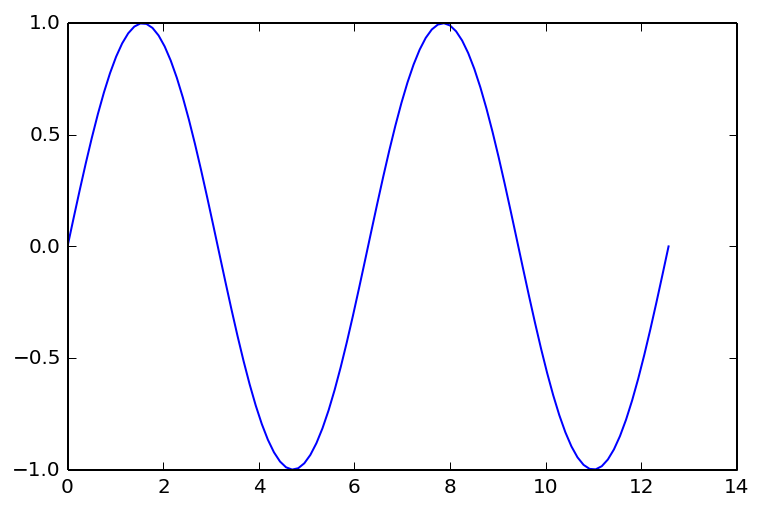

In [9]:
x = linspace(0, 4*pi, 100)
y = sin(x)
plot(x, y);

Again, I used a semicolon here to suppress the output of the last line, otherwise you'd get the result of the plot command which is some array containing all the elements of the plot. Not very helpful right now. The plot itself is displayed nevertheless.

## First steps with PyKat

Let's start using _PyKat_. First of all, we need to `import` it:

In [11]:
from pykat import finesse

                                              ..-
    PyKat 1.0.4           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



If you get any error messages at this step, _PyKat_ isn't installed and/or setup correctly. Ask for help.

Let's start with a very simple cavity, consisting of two mirrors `ITM` and `ETM`, and we look at the transmitted light while scanning the cavity across a resonance. If you know _Finesse_ already, then you can just use the standard _Finesse_ syntax:

In [120]:
finesse_code = """
l l1 1.0 0 nin
s s1 1.0 nin nITM_in
m2 ITM 0.95 0 0 nITM_in nITM_out
s s2 1.0 nITM_out nETM_in
m2 ETM 0.95 0 0 nETM_in nETM_out
s s3 1.0 nETM_out nout

pd PDtrans nout
xaxis ETM phi lin -200 200 400
yaxis lin abs
"""

The `"""` are a special _Python_ syntax for reading in a string consisting of multiple lines. In the next step, we need to create a new _PyKat_ object, and read in the code:

In [121]:
kat = finesse.kat()
kat.verbose = False
kat.parseKatCode(finesse_code)

You can also read in code from a `.kat` file that you have already created, by using the command

```python
kat.loadKatFile('/path/to/finesse_file.kat')
```

Let's run this simulation, and use the built-in `plot` command to display the output.

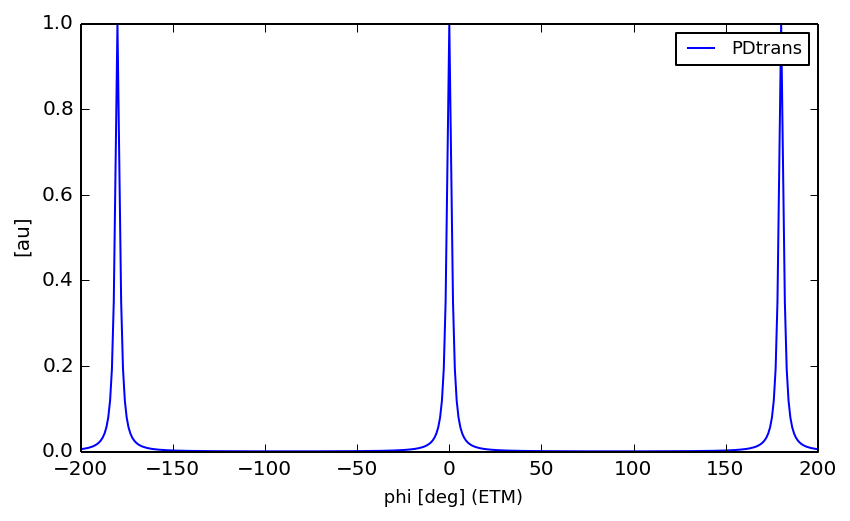

In [122]:
result = kat.run()
result.plot();

Simple! We can also manually plot the result, like this:

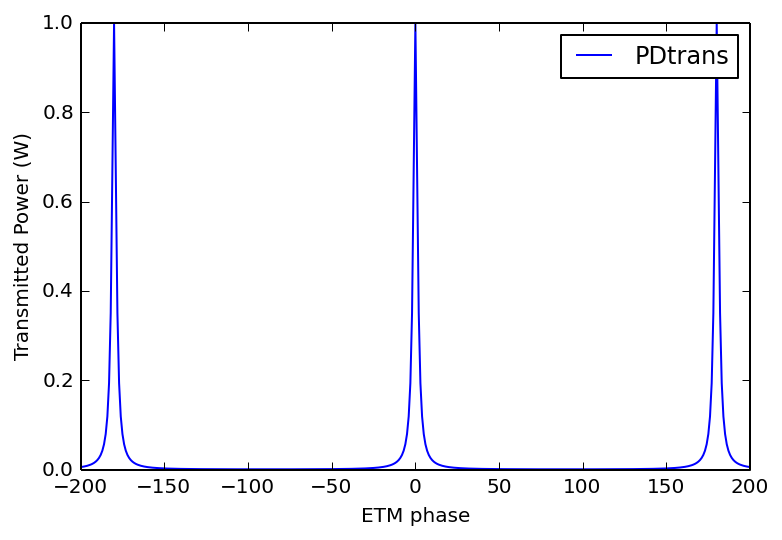

In [123]:
plot(result.x, result['PDtrans'])
xlabel('ETM phase')
ylabel('Transmitted Power (W)')
legend(['PDtrans']);

So far, we didn't do anything that _Finesse_ can't do on its own. _PyKat_ comes in really handy once you want to run the same simulation with different parameters. For example, we can redo the same plot for different mirror reflectivies. We first define a list of reflectivities that we want to use. Then we iterate over this list, updating the reflectivities of `ETM` and `ITM` (and adjusting the transmissivities accordingly). All plot commands from one cell are automatically accumulated into one single plot, so we can just plot each result individually. Note at this point that _Python_ is very strict about good code layout. You _have_ to indent everything inside a loop by either using `<tab>`s or `<space>`s.

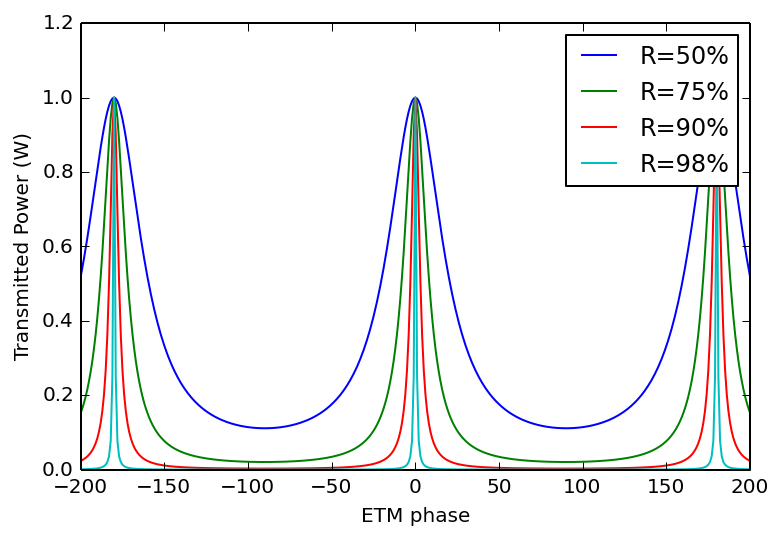

In [124]:
reflectivities = [0.5, 0.75, 0.9, 0.98]
for R in reflectivities:
    kat.ETM.R = R
    kat.ETM.T = 1-R
    kat.ITM.R = R
    kat.ITM.T = 1-R
    result = kat.run()
    plot(result.x, result['PDtrans'],
         label='R={:.0f}%'.format(R*100))

xlabel('ETM phase')
ylabel('Transmitted Power (W)')
legend();

Just a few lines of code, and done! The `legend` uses some fancy formatting, which is beyond the scope of this tutorial, but you can read up about it [here](https://docs.python.org/3.4/library/string.html#format-examples). 

## Quantum-noise simulations

Since version 2.0, _Finesse_ is able to calculate quantum noise, including radiation pressure noise. Even better, since 2.1 there's also a balanced homodyne detector available.

Let's try this out by creating the famous plots of a Michelson interferometer, where one sees that increasing the laser power decreases the shot-noise contribution at high frequencies, but increases the radiation-pressure noise contribution at low frequencies. We therefore need a simple Michelson interferometer, just two mirrors and a beam splitter:

In [143]:
finesse_code = """
l l1 100e3 0 nin
s s1 1.0 nin nBS_in

# main beam splitter
bs2 BS 0.5 0 0 45 nBS_in nBS_n nBS_e nBS_out

# north arm
s sN 1e3 nBS_n n_ETMn
m2 ETMn 1.0 0 0 n_ETMn dump
attr ETMn m 10

# east arm
s sE 1e3 nBS_e nETMe
m2 ETMe 1.0 0 90 nETMe dump
attr ETMe m 10

s s3 1.0 nBS_out nout

# differential signal
fsig fGW1 ETMn 1 0 0.5
fsig fGW2 ETMe 1 180 0.5

# sensitivity detector
qnoisedS PDsens 1 $fs nout
scale meter PDsens

xaxis fGW1 f log 0.1 1e3 400
yaxis log abs
"""
kat = finesse.kat()
kat.verbose = False
kat.parseKatCode(finesse_code)

New(ish) commands that were introduced for the quantum-noise calculation are the two `attr` lines, which set the mass of the ETMs to 10kg. We apply a differential signal to the end mirrors using the `fsig` command, with half the amplitude each. Then comes the `qnoised` detector. `qnoised` by itself detects only the quantum noise, while `qnoisedS` gives the shot-noise limited sensitivity by internally dividing the noise by the signal at that node. We need to give it a demodulation frequency at which we want to know the noise, here we set it to `$fs` so that it always looks at the frequency where we inject the signal. Using the `scale` command, we can get the output in ${\rm m}/\sqrt{\rm Hz}$. Finally, in the `xaxis` command we tell _Finesse_ to sweep the signal frequency from 0.1 Hz to 1 kHz.

Let's run this, for different laser powers:

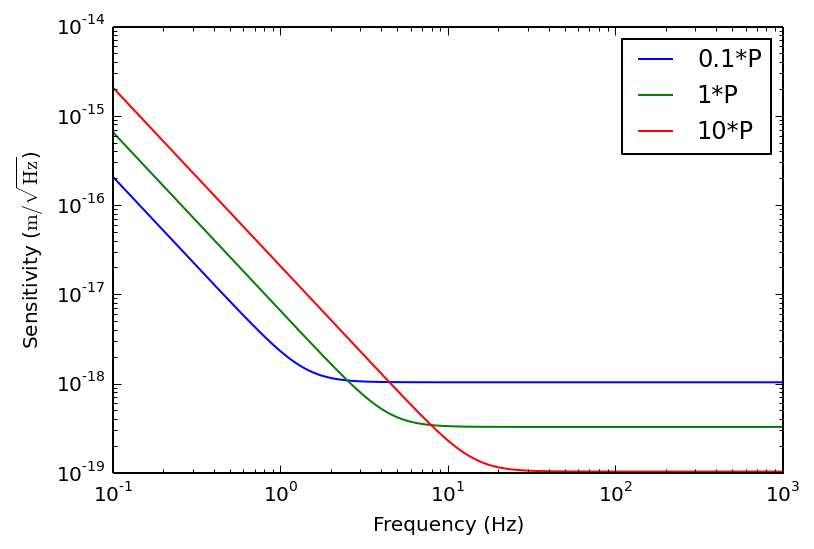

In [144]:
Pfactor = [0.1, 1, 10]
P = kat.l1.P.value
for factor in Pfactor:
    kat.l1.P = P*factor
    result = kat.run()
    loglog(result.x, result['PDsens'],
           label='{0}*P'.format(factor))
    
xlabel('Frequency (Hz)')
ylabel('Sensitivity ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)');
legend();

Note that (basic) LaTeX is supported in figure labels!

Now how about we add some squeezing? This works via the `sq` command, which needs a squeezing frequency (relative to the carrier), a squeezing strength in dB, and the squeezing angle.

In [145]:
kat = finesse.kat()
kat.verbose = False
kat.parseKatCode(finesse_code)
kat.parseKatCode('sq SQZ 0 10 0 nout')

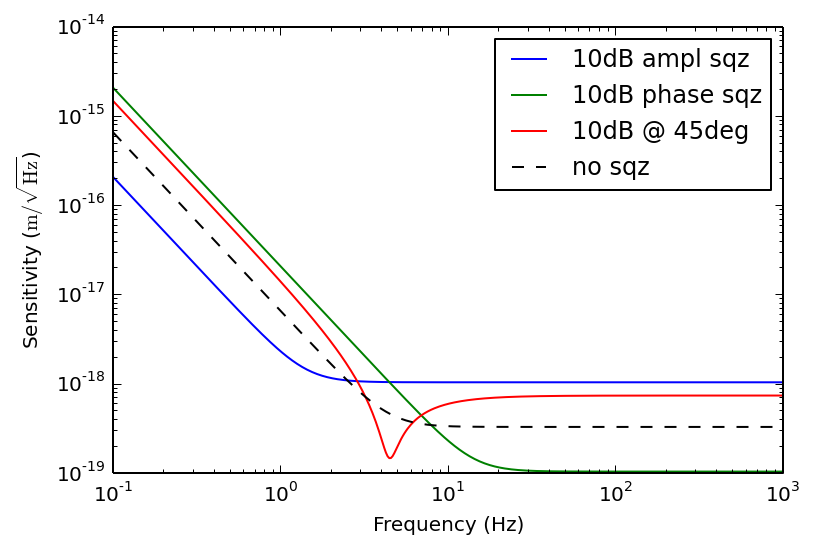

In [146]:
result = kat.run()
loglog(result.x, result['PDsens'], label='10dB ampl sqz')

kat.SQZ.angle = 90
result = kat.run()
loglog(result.x, result['PDsens'], label='10dB phase sqz')

kat.SQZ.angle = 45
result = kat.run()
loglog(result.x, result['PDsens'], label='10dB @ 45deg')

kat.SQZ.db = 0
result = kat.run()
loglog(result.x, result['PDsens'], 'k--', label='no sqz')

xlabel('Frequency (Hz)')
ylabel('Sensitivity ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)');
legend();

## Final words

This concludes our short introduction to _PyKat_, now go ahead and explore!

Good references are:

  * the built-in _Finesse_ help: `kat -h` and `kat -hh`
  * the _Finesse_ [manual](http://kvasir.sr.bham.ac.uk/redmine/attachments/download/131/Finesse_2.0_manual.pdf)
  * the [`CHANGES`](http://www.gwoptics.org/finesse/download/CHANGES) file (as the manual is not always up-to-date with the latest additions)
  * unfortunately, _PyKat_ itself isn't as well documented, but there are many [examples](https://gitlab.aei.uni-hannover.de/finesse/pykat/tree/master/examples) available
  
And if you are stuck: ask others! There are tons of _Finesse_ and _PyKat_ files around, and it's quite likely that someone will have solved your problem already. There's also a _Slack_ chat/messenger channel for _Finesse_ and _PyKat_ where the developers hang out regularly - ask for an invite if you're interested.